In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '22'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20220831WEDFB1772', '2022-Aug-31', '00:30:00', 'Italian Division 1 [ISA]', 'Sassuolo', 'AC Milan', 'true', '9.5', '1.81', '1.89', 'false', '10.5', '2.27', '1.56', 'false', '13.5', '4.90', '1.13']
['20220831WEDFB1760', '2022-Aug-31', '02:30:00', 'Eng Premier [EPL]', 'Crystal Palace', 'Brentford', 'true', '10.5', '2.20', '1.59', 'false', '11.5', '2.80', '1.38', 'false', '13.5', '4.75', '1.14']
['20220831WEDFB1763', '2022-Aug-31', '02:30:00', 'Eng Premier [EPL]', 'Fulham', 'Brighton', 'true', '10.5', '2.13', '1.63', 'false', '11.5', '2.65', '1.42', 'false', '13.5', '4.55', '1.15']
['20220831WEDFB1761', '2022-Aug-31', '02:45:00', 'Eng Premier [EPL]', 'Southampton', 'Chelsea', 'true', '10.5', '1.85', '1.85', 'false', '11.5', '2.30', '1.54', 'false', '14.5', '4.55', '1.15']
['20220831WEDFB1771', '2022-Aug-31', '02:45:00', 'Italian Division 1 [ISA]', 'Inter Milan', 'Cremonese', 'true', '10.5', '1.97', '1.74', 'false', '11.5', '2.50', '1.46', 'false', '14.5', '5.30', '1.11']
['20220831WEDFB1

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [13]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [14]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20220831WEDFB1772,2022-Aug-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,true,9.5,1.81,1.89,false,10.5,2.27,1.56,false,13.5,4.90,1.13
1,20220831WEDFB1760,2022-Aug-31,02:30:00,Eng Premier [EPL],Crystal Palace,Brentford,true,10.5,2.20,1.59,false,11.5,2.80,1.38,false,13.5,4.75,1.14
2,20220831WEDFB1763,2022-Aug-31,02:30:00,Eng Premier [EPL],Fulham,Brighton,true,10.5,2.13,1.63,false,11.5,2.65,1.42,false,13.5,4.55,1.15
3,20220831WEDFB1761,2022-Aug-31,02:45:00,Eng Premier [EPL],Southampton,Chelsea,true,10.5,1.85,1.85,false,11.5,2.30,1.54,false,14.5,4.55,1.15
4,20220831WEDFB1771,2022-Aug-31,02:45:00,Italian Division 1 [ISA],Inter Milan,Cremonese,true,10.5,1.97,1.74,false,11.5,2.50,1.46,false,14.5,5.30,1.11
5,20220831WEDFB1770,2022-Aug-31,02:45:00,Italian Division 1 [ISA],Roma,Monza,true,10.5,2.10,1.65,false,11.5,2.68,1.41,false,14.5,5.80,1.09
6,20220831WEDFB1762,2022-Aug-31,03:00:00,Eng Premier [EPL],Leeds,Everton,true,10.5,1.98,1.73,false,11.5,2.50,1.46,false,13.5,4.05,1.19
7,20220831WEDFB1811,2022-Aug-31,08:30:00,Copa Libertadores [LBC],Athletico Paranaense,Palmeiras,true,10.5,2.04,1.69,false,11.5,2.60,1.43,false,13.5,4.55,1.15
8,20220831WEDFB1851,2022-Aug-31,17:30:00,Australian FA Cup [AFA],Adelaide Utd,Brisbane Roar,true,10.5,1.85,1.85,false,11.5,2.30,1.54,false,14.5,4.55,1.15
9,20220831WEDFB1850,2022-Aug-31,17:30:00,Australian FA Cup [AFA],Macarthur FC,Wellington Phoenix,true,10.5,1.73,1.98,false,11.5,2.10,1.65,false,14.5,4.15,1.18


In [15]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [16]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [17]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [18]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [19]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [20]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [21]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [21]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [22]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [23]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [24]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [25]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [26]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [27]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [28]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [29]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [30]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [31]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [32]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,WEDFB1772,WEDFB1771,WEDFB1770,THUFB1836,THUFB1837
Date,2022-08-31 00:00:00,2022-08-31 00:00:00,2022-08-31 00:00:00,2022-09-01 00:00:00,2022-09-01 00:00:00
Time,00:30:00,02:45:00,02:45:00,00:30:00,00:30:00
LeagueJC,Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA]
HomeTeamJC,Sassuolo,Inter Milan,Roma,Sampdoria,Udinese
AwayTeamJC,AC Milan,Cremonese,Monza,Lazio,Fiorentina
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,9.5,10.5,10.5,9.5,9.5
CHL_H_0,1.81,1.97,2.1,2.02,1.8
CHL_L_0,1.89,1.74,1.65,1.7,1.9


## Load model

In [33]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [34]:
to = load_pandas('models/to.pkl')

In [35]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [36]:
odds = odds.dropna(how='any')

In [37]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [38]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,I1,Sassuolo,Milan,16.4,5.8,19.2,6.6,15.4,16.0,12.0,11.4
1,I1,Inter,Cremonese,21.2,8.4,12.4,4.2,23.8,12.8,7.0,18.2
2,I1,Roma,Monza,20.8,10.2,13.4,5.4,22.6,13.6,11.2,16.8
3,I1,Sampdoria,Lazio,9.2,3.4,15.8,5.8,10.2,13.8,14.8,8.8
4,I1,Udinese,Fiorentina,14.4,4.8,11.2,3.2,14.6,16.6,16.2,7.2
5,I1,Empoli,Verona,13.2,5.2,13.4,3.2,9.8,11.0,26.6,18.0
6,I1,Juventus,Spezia,16.2,4.6,8.4,3.6,8.2,8.4,15.6,16.2
7,I1,Napoli,Lecce,15.8,5.6,13.0,4.0,17.0,15.2,9.4,10.4
8,I1,Atalanta,Torino,22.4,10.6,10.8,4.4,17.8,11.4,10.6,11.4
9,I1,Bologna,Salernitana,10.8,3.6,12.2,4.4,14.0,19.2,16.0,15.8


In [39]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [40]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [41]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [42]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [43]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [44]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [45]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [46]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,WEDFB1772,2022-08-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,True,9.5,1.81,1.89,0.056988,0.067152,5.461098,5.344111,-51.040264,-0.100672
1,WEDFB1771,2022-08-31,02:45:00,Italian Division 1 [ISA],Inter Milan,Cremonese,True,10.5,1.97,1.74,0.053280,0.169809,7.409552,3.234248,-51.279842,-0.187950
2,WEDFB1770,2022-08-31,02:45:00,Italian Division 1 [ISA],Roma,Monza,True,10.5,2.10,1.65,0.059824,0.078497,6.743957,3.946050,-48.266773,-0.109087
3,THUFB1836,2022-09-01,00:30:00,Italian Division 1 [ISA],Sampdoria,Lazio,True,9.5,2.02,1.70,0.079034,0.064928,4.613073,5.564802,-48.513851,-0.116744
4,THUFB1837,2022-09-01,00:30:00,Italian Division 1 [ISA],Udinese,Fiorentina,True,9.5,1.80,1.90,0.101066,0.064215,4.011858,6.162513,-48.886002,-0.140663


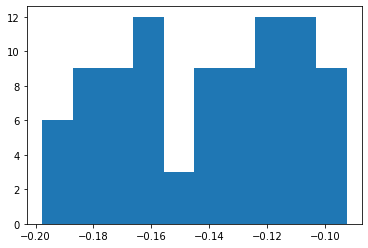

In [47]:
odds['corr'].hist(grid=False);

In [48]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [49]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [50]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [51]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [52]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [53]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [54]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [55]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [56]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
2,WEDFB1772,2022-08-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,True,9.5,1.81,1.89,0.618870,0.381130,0.148340,High,$
3,WEDFB1761,2022-08-31,02:45:00,Eng Premier [EPL],Southampton,Chelsea,True,10.5,1.85,1.85,0.398044,0.601956,0.133670,Low,$
5,THUFB1833,2022-09-01,00:30:00,Italian Division 1 [ISA],Empoli,Verona,True,10.5,2.15,1.62,0.526281,0.473719,0.114351,High,$
6,THUFB1836,2022-09-01,00:30:00,Italian Division 1 [ISA],Sampdoria,Lazio,True,9.5,2.02,1.70,0.549810,0.450190,0.108448,High,$


In [57]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,WEDFB1761,2022-08-31,02:45:00,Eng Premier [EPL],Southampton,Chelsea,False,14.5,4.55,1.15,0.095581,0.904419,0.267216,Low,None
1,WEDFB1761,2022-08-31,02:45:00,Eng Premier [EPL],Southampton,Chelsea,False,11.5,2.30,1.54,0.296824,0.703176,0.153501,Low,None
2,WEDFB1772,2022-08-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,True,9.5,1.81,1.89,0.618870,0.381130,0.148340,High,$
3,WEDFB1761,2022-08-31,02:45:00,Eng Premier [EPL],Southampton,Chelsea,True,10.5,1.85,1.85,0.398044,0.601956,0.133670,Low,$
4,WEDFB1772,2022-08-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,False,10.5,2.27,1.56,0.507053,0.492947,0.118906,High,None
5,THUFB1833,2022-09-01,00:30:00,Italian Division 1 [ISA],Empoli,Verona,True,10.5,2.15,1.62,0.526281,0.473719,0.114351,High,$
6,THUFB1836,2022-09-01,00:30:00,Italian Division 1 [ISA],Sampdoria,Lazio,True,9.5,2.02,1.70,0.549810,0.450190,0.108448,High,$
9,THUFB1836,2022-09-01,00:30:00,Italian Division 1 [ISA],Sampdoria,Lazio,False,10.5,2.60,1.43,0.436208,0.563792,0.083839,High,None
11,THUFB1833,2022-09-01,00:30:00,Italian Division 1 [ISA],Empoli,Verona,False,11.5,2.70,1.40,0.417475,0.582525,0.074814,High,None
19,WEDFB1772,2022-08-31,00:30:00,Italian Division 1 [ISA],Sassuolo,AC Milan,False,13.5,4.90,1.13,0.218358,0.781642,0.017937,High,None


In [58]:
odds.to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)